In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
sns.set_context('talk')

In [5]:
import average_precision

In [6]:
import datetime

# Thoughts

Нам нужно предсказать для каждого пользователя пять категорий в порядке убывания, на товарные предложения внутри которых он кликал чаще всего за восьмую неделю. 

Можно выделить седьмую неделю и валидироваться по аггрегированным кликам для неё.

Для начала будем работать только с train_clicks и train_category_views. Только с полями user_id, category_id, day

In [7]:
views = pd.read_csv('data/train_category_views.csv', parse_dates=['day'])
clicks = pd.read_csv('data/train_clicks.csv', parse_dates=['day'])[views.columns]

In [8]:
test_users = pd.read_csv('data/test_users.csv')

In [9]:
clicks.head()

,user_id,category_id,day
0,46,672,2016-08-04
1,48,170,2016-08-04
2,48,170,2016-08-04
3,53,1190,2016-08-04
4,93,56,2016-08-04


In [10]:
clicks.day.max() - clicks.day.min()

Timedelta('52 days 00:00:00')

In [11]:
clicks.category_id.max()

2653

In [12]:
views.category_id.max()

2682

Переведём данные в "клики (просмотры) в день пользователя по категории"

In [10]:
agg_views = views.copy()
agg_views['count'] = 1
agg_views = agg_views.groupby(['user_id', 'day', 'category_id']).count().sort_index()

In [11]:
agg_clicks = clicks.copy()
agg_clicks['count'] = 1
agg_clicks = agg_clicks.groupby(['user_id', 'day', 'category_id']).count().sort_index()

In [12]:
(clicks.groupby('user_id').day.max() - clicks.groupby('user_id').day.min()).median()

Timedelta('0 days 00:00:00')

In [13]:
(views.groupby('user_id').day.max() - views.groupby('user_id').day.min()).median()

Timedelta('0 days 00:00:00')

In [14]:
clicks.groupby('user_id')['category_id'].count().median()

2.0

In [15]:
clicks.groupby('user_id')['category_id'].count().mean()

3.9594260406245434

In [16]:
(clicks.groupby('user_id')['category_id'].count() > 4).sum()

38643

In [20]:
clicks['user_id'].nunique()

177922

А давайте мягко предсказывать категорию, на которую больше всего накликает пользователь. Как ответ будет давать упорядоченную пятёрку топ-5 предсказаний. Как y_train будет soft_max от накликанного

Можно пытаться предсказать поведение среднего пользователя.

In [17]:
len(set(test_users.user_id) - set(clicks.user_id))

0

In [18]:
test_users.shape

(31712, 1)

In [20]:
clicks[clicks.user_id.isin(set(test_users.user_id))].groupby('user_id')['category_id'].count().median()

3.0

In [21]:
clicks[clicks.user_id.isin(set(test_users.user_id))].groupby('user_id')['category_id'].count().mean()

6.8187752270433908

In [36]:
clicks[clicks.user_id.isin(set(test_users.user_id))].groupby('user_id')['day'].max().min()

Timestamp('2016-09-20 00:00:00')

In [49]:
clicks[clicks.user_id.isin(set(test_users.user_id))].groupby('user_id')['day'].count().sort_values(ascending=False)

user_id
78036     487
31407     480
185942    431
179927    367
77906     334
91671     320
33654     267
52846     266
13303     264
46427     260
35698     253
44708     245
73402     233
133443    230
140650    222
30457     205
26267     195
111101    193
37938     192
113619    186
118140    179
11399     173
60817     172
109296    171
42618     170
192180    169
151581    168
4619      168
155819    167
129663    166
         ... 
84402       1
84706       1
84751       1
85119       1
84915       1
85116       1
85090       1
85034       1
85021       1
84989       1
84957       1
84953       1
84940       1
177745      1
84931       1
84922       1
177773      1
84772       1
84884       1
84871       1
84862       1
177775      1
84830       1
177790      1
84822       1
177796      1
177805      1
84793       1
84792       1
199977      1
Name: day, dtype: int64

In [33]:
clicks[clicks.user_id.isin(set(test_users.user_id))].groupby(['user_id', 'day', 'category_id']).count().sort_index()

Empty DataFrame
Columns: []
Index: [(8, 2016-08-06 00:00:00, 134), (8, 2016-08-17 00:00:00, 134), (8, 2016-08-17 00:00:00, 795), (8, 2016-08-18 00:00:00, 1244), (8, 2016-08-23 00:00:00, 1409), (8, 2016-08-26 00:00:00, 108), (8, 2016-08-26 00:00:00, 937), (8, 2016-08-26 00:00:00, 970), (8, 2016-09-11 00:00:00, 2330), (8, 2016-09-12 00:00:00, 103), (8, 2016-09-12 00:00:00, 755), (8, 2016-09-18 00:00:00, 429), (8, 2016-09-22 00:00:00, 1079), (12, 2016-09-24 00:00:00, 1898), (27, 2016-09-22 00:00:00, 200), (39, 2016-08-23 00:00:00, 160), (39, 2016-09-20 00:00:00, 2138), (40, 2016-09-21 00:00:00, 2273), (45, 2016-09-15 00:00:00, 1407), (45, 2016-09-21 00:00:00, 431), (57, 2016-09-21 00:00:00, 2096), (67, 2016-08-08 00:00:00, 1404), (67, 2016-09-22 00:00:00, 163), (67, 2016-09-23 00:00:00, 163), (68, 2016-09-25 00:00:00, 1821), (68, 2016-09-25 00:00:00, 1826), (70, 2016-08-09 00:00:00, 2040), (70, 2016-08-09 00:00:00, 2141), (70, 2016-08-17 00:00:00, 873), (70, 2016-08-19 00:00:00, 135), (70, 2016-09-01 00:00:00, 163), (70, 2016-09-11 00:00:00, 2173), (70, 2016-09-20 00:00:00, 237), (70, 2016-09-24 00:00:00, 135), (75, 2016-08-16 00:00:00, 1105), (75, 2016-08-25 00:00:00, 1105), (75, 2016-08-27 00:00:00, 1105), (75, 2016-09-05 00:00:00, 672), (75, 2016-09-12 00:00:00, 1105), (75, 2016-09-18 00:00:00, 1948), (75, 2016-09-21 00:00:00, 1948), (77, 2016-08-20 00:00:00, 431), (77, 2016-09-24 00:00:00, 486), (77, 2016-09-24 00:00:00, 1215), (77, 2016-09-24 00:00:00, 2115), (86, 2016-08-15 00:00:00, 954), (86, 2016-08-24 00:00:00, 1070), (86, 2016-08-24 00:00:00, 1086), (86, 2016-08-28 00:00:00, 1251), (86, 2016-09-05 00:00:00, 1351), (86, 2016-09-05 00:00:00, 1361), (86, 2016-09-08 00:00:00, 873), (86, 2016-09-08 00:00:00, 1246), (86, 2016-09-16 00:00:00, 1241), (86, 2016-09-16 00:00:00, 2104), (86, 2016-09-17 00:00:00, 2193), (86, 2016-09-24 00:00:00, 672), (96, 2016-09-09 00:00:00, 103), (96, 2016-09-24 00:00:00, 547), (100, 2016-08-11 00:00:00, 124), (100, 2016-08-15 00:00:00, 135), (100, 2016-08-22 00:00:00, 1321), (100, 2016-08-30 00:00:00, 804), (100, 2016-09-12 00:00:00, 2178), (100, 2016-09-22 00:00:00, 2081), (109, 2016-08-09 00:00:00, 1063), (109, 2016-08-15 00:00:00, 440), (109, 2016-08-22 00:00:00, 422), (109, 2016-08-22 00:00:00, 459), (109, 2016-08-24 00:00:00, 462), (109, 2016-08-29 00:00:00, 444), (109, 2016-08-29 00:00:00, 446), (109, 2016-08-30 00:00:00, 672), (109, 2016-08-31 00:00:00, 1360), (109, 2016-08-31 00:00:00, 1361), (109, 2016-09-21 00:00:00, 1088), (109, 2016-09-22 00:00:00, 1351), (109, 2016-09-23 00:00:00, 672), (113, 2016-08-04 00:00:00, 2124), (113, 2016-08-09 00:00:00, 1201), (113, 2016-08-25 00:00:00, 1180), (113, 2016-08-27 00:00:00, 1138), (113, 2016-08-28 00:00:00, 20), (113, 2016-08-29 00:00:00, 1138), (113, 2016-09-01 00:00:00, 772), (113, 2016-09-01 00:00:00, 2242), (113, 2016-09-06 00:00:00, 1170), (113, 2016-09-11 00:00:00, 1336), (113, 2016-09-13 00:00:00, 1141), (113, 2016-09-15 00:00:00, 1141), (113, 2016-09-19 00:00:00, 1180), (113, 2016-09-25 00:00:00, 688), (131, 2016-08-18 00:00:00, 435), (131, 2016-08-24 00:00:00, 435), (131, 2016-09-13 00:00:00, 1445), (131, 2016-09-13 00:00:00, 1939), (131, 2016-09-20 00:00:00, 1445), (131, 2016-09-21 00:00:00, 1931), (131, 2016-09-22 00:00:00, 1826), (133, 2016-09-23 00:00:00, 197), ...]

[105256 rows x 0 columns]

In [41]:
clicks.day.max()

Timestamp('2016-09-25 00:00:00')

In [42]:
views.day.max()

Timestamp('2016-09-25 00:00:00')

In [44]:
views.day.min()

Timestamp('2016-08-04 00:00:00')

Все пользователи из теста есть в трейне

In [22]:
test_users.head()

,user_id
0,8
1,12
2,27
3,39
4,40


In [34]:
agg_clicks

count
user_id day        category_id       
0       2016-08-25 672              1
1       2016-08-19 428              1
        2016-09-01 44               2
                   1967             2
2       2016-08-11 892              1
3       2016-08-06 1257             1
        2016-08-10 2318             1
        2016-08-17 1351             1
4       2016-08-10 108              1
5       2016-08-12 2149             2
6       2016-08-15 977              1
7       2016-08-10 696              1
8       2016-08-06 134              1
        2016-08-17 134              5
                   795              1
        2016-08-18 1244             1
        2016-08-23 1409             7
        2016-08-26 108              5
                   937              1
                   970              3
        2016-09-11 2330             3
        2016-09-12 103              1
                   755              3
        2016-09-18 429              4
        2016-09-22 1079             3
9       2016-08-11 672              1
11      2016-08-31 1407             1
12      2016-09-24 1898             1
13      2016-08-30 672              2
14      2016-09-06 672              1
...                               ...
199983  2016-09-09 911              1
        2016-09-10 911              2
        2016-09-12 127              2
199985  2016-09-09 1339             4
199986  2016-08-12 911              1
        2016-08-21 171              4
        2016-08-22 749              1
                   1238             1
        2016-08-30 1524             1
        2016-09-02 197              1
        2016-09-17 177              3
                   1454            12
199987  2016-08-11 40               1
199988  2016-08-09 192              1
199989  2016-08-15 422              1
199990  2016-08-15 2540             1
199991  2016-08-22 1193             9
199992  2016-08-28 440              1
199994  2016-09-01 1186             1
        2016-09-04 1270             1
        2016-09-19 938              2
199995  2016-08-11 1204             1
        2016-09-09 672              1
        2016-09-12 1409             1
199996  2016-08-14 369              1
                   1289             1
199997  2016-08-17 1288             1
199998  2016-08-10 2012             1
199999  2016-08-18 672              1
        2016-09-05 553              1

[364518 rows x 1 columns]

In [49]:
print(datetime.date(2016, 8, 3))

2016-08-03


In [51]:
clicks[(datetime.date(2016, 8, 3) < clicks.day) & (clicks.day < datetime.date(2016, 8, 11))].category_id.value_counts()[:5]

672    10456
134     1513
66      1484
424     1329
163     1279
Name: category_id, dtype: int64

In [53]:
clicks[(datetime.date(2016, 9, 18) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:5]

672    12417
66      2566
163     1729
424     1615
134     1188
Name: category_id, dtype: int64

In [62]:
clicks[(datetime.date(2016, 9, 19) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:5]

672     10697
66       2205
163      1494
424      1411
1409      986
Name: category_id, dtype: int64

In [61]:
clicks[(datetime.date(2016, 9, 24) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:5]

672     1516
66       329
163      247
424      198
1409     142
Name: category_id, dtype: int64

In [63]:
last_days_answer = "672 66 163 424 1409"

In [67]:
views[(datetime.date(2016, 9, 18) < views.day) & (views.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:5]

672    18303
663     3003
163     2958
424     2845
66      2696
Name: category_id, dtype: int64

In [73]:
views[(datetime.date(2016, 9, 24) < views.day) & (views.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:5]

672    2402
663     416
424     353
163     348
66      286
Name: category_id, dtype: int64

In [75]:
clicks[(datetime.date(2016, 9, 18) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))].category_id.value_counts()[:10]

672     12417
66       2566
163      1729
424      1615
134      1188
1409     1130
120      1123
440       913
674       777
237       705
Name: category_id, dtype: int64

In [76]:
clicks[(datetime.date(2016, 9, 11) < clicks.day) & (clicks.day < datetime.date(2016, 9, 19))].category_id.value_counts()[:10]

672     12395
66       2307
424      1882
163      1676
134      1445
1409     1068
440       939
674       820
120       798
110       696
Name: category_id, dtype: int64

Предсказание последних дней даёт 0.037 скора. Наша модель с затуханием схватывает эффект последних дней, но экстраполирует константой, не пытаясь эстраполировать более сложными функциями

Выделим седьмую неделю

In [ ]:
def split_by_date(df, date):
    

In [ ]:
train_agg_views, validation_agg_views = split_by_date(agg_views, views.day.max() - datetime.timedelta(6))

In [14]:
user_profile = pd.read_csv('data/train_user_profile.csv', parse_dates=['day'])

In [15]:
user_profile.user_id.nunique()

53428

In [12]:
test_users.shape

(31712, 1)

In [16]:
len(set(test_users.user_id) - set(user_profile.user_id))

22120

Чёт всё гавно какое-то. Возьмём бейзлайн, и потюним его

In [25]:
clicks.day.dt.dayofyear

0         217
1         217
2         217
3         217
4         217
5         217
6         217
7         217
8         217
9         217
10        217
11        217
12        217
13        217
14        217
15        217
16        217
17        217
18        217
19        217
20        217
21        217
22        217
23        217
24        217
25        217
26        217
27        217
28        217
29        217
         ... 
704439    269
704440    269
704441    269
704442    269
704443    269
704444    269
704445    269
704446    269
704447    269
704448    269
704449    269
704450    269
704451    269
704452    269
704453    269
704454    269
704455    269
704456    269
704457    269
704458    269
704459    269
704460    269
704461    269
704462    269
704463    269
704464    269
704465    269
704466    269
704467    269
704468    269
Name: day, dtype: int64

In [225]:
number_of_categories = max(max(clicks.category_id), max(views.category_id))
number_of_users = max(max(clicks.user_id), max(views.user_id))

In [226]:
last_clicks = clicks[(datetime.date(2016, 9, 11) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))]

Каждую неделю есть 30 тысяч активых

In [250]:
datetime.date(2016, 9, 18) + datetime.timedelta(1)

datetime.date(2016, 9, 19)

In [256]:
first_day = clicks.day.min() - datetime.timedelta(1)

for i in range(53 - 7):
    print(clicks[(first_day + datetime.timedelta(i) < clicks.day) &\
                 (clicks.day < first_day + datetime.timedelta(i + 8))].user_id.nunique())

32724
32673
32629
32735
33197
33564
33772
33849
33868
33902
34025
33692
33511
33390
33402
33473
33401
33514
33723
33910
34037
34001
33766
33567
33599
33869
33838
33634
33467
33730
34040
34275
34300
34488
34665
34564
34236
34222
34483
34496
34898
35213
35709
36211
36524
36637


In [270]:
first_day = clicks.day.min() - datetime.timedelta(1)
week_num = 2

for i in range(53 - 7 * (week_num + 1)):
    first_set = set(clicks[(first_day + datetime.timedelta(i) < clicks.day) &\
                 (clicks.day < first_day + datetime.timedelta(i + 1 + 7 * week_num))].user_id)
    second_set = set(clicks[(first_day + datetime.timedelta(i + 7 * week_num) < clicks.day) &\
                 (clicks.day < first_day + datetime.timedelta(i + 1 + 7 * (week_num + 1)))].user_id)
    print(len(second_set - first_set))

23687
23714
23709
23727
23870
23967
24080
24068
23896
23824
23744
23986
23901
23653
23543
23795
24151
24287
24214
24353
24454
24445
24195
24205
24362
24397
24652
24917
25452
25889
26134
26108


In [438]:
first_day = clicks.day.min() - datetime.timedelta(1)
week_num = 2

for i in range(53 - 7 * (week_num + 1)):
    zero_set = set(clicks[(first_day + datetime.timedelta(i) < clicks.day) &\
             (clicks.day < first_day + datetime.timedelta(i + 1 + 7 * week_num))].user_id)
    first_set = set(views[(first_day + datetime.timedelta(i) < views.day) &\
                 (views.day < first_day + datetime.timedelta(i + 1 + 7 * week_num))].user_id)
    second_set = set(clicks[(first_day + datetime.timedelta(i + 7 * week_num) < clicks.day) &\
                 (clicks.day < first_day + datetime.timedelta(i + 1 + 7 * (week_num + 1)))].user_id)
    print(len(second_set - first_set - zero_set))

22433
22485
22472
22509
22628
22700
22868
22880
22706
22652
22548
22754
22687
22442
22338
22553
22896
22990
22917
22985
23087
23087
22853
22878
23001
23061
23258
23454
23912
24324
24540
24489


Как ни увеличивай промежуток для трейна, всё равно дофигищи непокрытых пользователей. Остановимся на двух неделях

Мы уже можем относительно хорошо предсказывать рейтинг категорий. Это можно использовать для тёмных пользователей. 

Есть примерно 10 тысяч пользователей, которые есть в трейн-неделях и тестовой неделе. 

In [445]:
number_of_categories = max(max(clicks.category_id), max(views.category_id))
number_of_users = max(max(clicks.user_id), max(views.user_id))

In [446]:
last_clicks = clicks[(datetime.date(2016, 9, 11) < clicks.day) & (clicks.day < datetime.date(2016, 9, 26))]

In [447]:
user_clicks = np.zeros((number_of_users + 1, number_of_categories + 1))
for row in last_clicks.iterrows():
    _, row = row
    #user_clicks[row['user_id'], row['category_id']] += np.exp((row.day.dayofyear - 269) / 7)
    user_clicks[row['user_id'], row['category_id']] += coefs[row.day.dayofyear - (270 - 14)]

In [448]:
user_clicks.sum()

100887.66554710321

In [449]:
user_clicks[test_users.user_id.reshape(-1), :].sum()

68940.934138166049

In [450]:
user_clicks.shape

(200000, 2683)

divider = user_clicks.sum(axis=1).reshape((-1, 1))
divider = np.where(divider > 0, divider, 1)

user_clicks /= divider

In [451]:
average_clicks = user_clicks.sum(axis=0)

In [452]:
average_clicks /= user_clicks.shape[0]

In [453]:
user_clicks += average_clicks / 10

In [454]:
test_categories = np.argsort(-user_clicks[test_users.user_id.values.reshape(-1), :], axis=1)[:, :5]

In [455]:
test_categories[:5]

array([[ 429, 1079,  755,  103,  672],
       [1898,  672,   66,  163,  424],
       [ 200,  672,   66,  163,  424],
       [2138,  672,   66,  163,  424],
       [2273,  672,   66,  163,  424]])

In [240]:
def join_categories(row):
    base_str = ' '.join(map(str, row))
    return base_str + ' '*(25 - len(base_str))

In [456]:
test_users['categories'] = np.apply_along_axis(join_categories, 1, test_categories)

In [457]:
test_users.head()

,user_id,categories
0,8,429 1079 755 103 672
1,12,1898 672 66 163 424
2,27,200 672 66 163 424
3,39,2138 672 66 163 424
4,40,2273 672 66 163 424


In [458]:
test_users.to_csv('csv/baseline_new_coeffs.csv', index=None)

Пока есть два параметра -- затухание и сглаживание средним

In [70]:
average_user_clicks = np.zeros((269 - 217 + 1, number_of_categories + 1))
for row in clicks.iterrows():
    _, row = row
    average_user_clicks[row['day'].dayofyear - 217, row['category_id']] += 1

In [76]:
average_user_clicks.shape

(53, 2683)

In [293]:
df_avuscl = pd.DataFrame(average_user_clicks.T)

In [294]:
df_avuscl[df_avuscl.sum(axis=1) > 50].shape

(1303, 53)

In [352]:
df_nzero_avuscl = df_avuscl[df_avuscl.sum(axis=1) > 200]
df_nzero_avuscl.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
6,35.0,28.0,56.0,63.0,81.0,29.0,42.0,39.0,25.0,40.0,30.0,40.0,43.0,40.0,42.0,37.0,21.0,16.0,40.0,35.0,39.0,19.0,36.0,69.0,47.0,29.0,41.0,43.0,25.0,38.0,36.0,27.0,49.0,54.0,42.0,52.0,27.0,47.0,47.0,45.0,42.0,32.0,50.0,38.0,40.0,48.0,44.0,31.0,59.0,46.0,32.0,44.0,33.0
8,10.0,7.0,4.0,9.0,18.0,10.0,11.0,11.0,2.0,13.0,5.0,6.0,13.0,11.0,30.0,19.0,34.0,6.0,20.0,13.0,30.0,13.0,16.0,7.0,15.0,22.0,14.0,28.0,6.0,16.0,16.0,5.0,5.0,20.0,27.0,14.0,6.0,27.0,18.0,24.0,16.0,22.0,14.0,34.0,7.0,17.0,23.0,7.0,38.0,17.0,39.0,10.0,21.0
9,2.0,9.0,5.0,1.0,2.0,12.0,4.0,5.0,1.0,2.0,3.0,0.0,3.0,2.0,6.0,3.0,3.0,4.0,11.0,8.0,2.0,3.0,1.0,15.0,4.0,5.0,3.0,11.0,10.0,11.0,5.0,7.0,7.0,1.0,21.0,8.0,0.0,4.0,1.0,4.0,0.0,1.0,5.0,2.0,2.0,6.0,11.0,11.0,16.0,13.0,2.0,3.0,1.0
10,5.0,14.0,2.0,2.0,4.0,11.0,12.0,2.0,1.0,5.0,1.0,7.0,3.0,3.0,3.0,6.0,3.0,6.0,2.0,0.0,7.0,8.0,8.0,1.0,9.0,5.0,4.0,12.0,8.0,1.0,0.0,11.0,7.0,7.0,8.0,0.0,4.0,2.0,3.0,5.0,2.0,3.0,14.0,20.0,13.0,1.0,9.0,8.0,5.0,12.0,13.0,2.0,2.0
13,6.0,5.0,9.0,5.0,9.0,1.0,7.0,3.0,2.0,4.0,2.0,3.0,6.0,0.0,8.0,11.0,9.0,1.0,4.0,5.0,10.0,6.0,0.0,7.0,12.0,2.0,4.0,4.0,7.0,9.0,1.0,2.0,3.0,8.0,4.0,9.0,11.0,0.0,5.0,20.0,5.0,0.0,4.0,14.0,0.0,3.0,5.0,3.0,0.0,0.0,1.0,2.0,3.0


Будет по 14 дням предсказывать сумму за следующие 7

In [353]:
avuscl_cumsum = np.cumsum(df_nzero_avuscl.values, axis=1)

In [354]:
nzero_avuscl = df_nzero_avuscl.values

In [355]:
nzero_avuscl.shape

(623, 53)

In [356]:
avuscl_cumsum.shape

(623, 53)

In [383]:
three_week_X = np.vstack([nzero_avuscl[:, i: i+14] for i in range(3, 53 - 21, 1)])

In [384]:
three_week_X.shape

(18067, 14)

In [385]:
three_week_y = np.hstack([(avuscl_cumsum[:, i] - avuscl_cumsum[:, i - 7]) for i in range(24, 53, 1)])

In [386]:
three_week_y.shape

(18067,)

In [387]:
three_week_X[0]

array([ 63.,  81.,  29.,  42.,  39.,  25.,  40.,  30.,  40.,  43.,  40.,
        42.,  37.,  21.])

In [388]:
three_week_y[0]

285.0

In [176]:
from sklearn.svm import LinearSVR

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(8, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MSE')

In [374]:
def learn(clf, params, X_train, y_train):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=5, scoring='mean_squared_error', n_jobs=3)
    grid_searcher.fit(X_train, y_train)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [424]:
%%time

params = {"loss": ["squared_loss", "huber", "epsilon_insensitive"]}
params = {'C' : [0.1 ** i for i in range(3, 8)]}

searcher = learn(LinearSVR(random_state=42, epsilon=1, loss="squared_epsilon_insensitive", fit_intercept=False), 
                 params, three_week_X, three_week_y)

-1518.07514331
LinearSVR(C=0.00010000000000000002, dual=True, epsilon=1, fit_intercept=False,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=42, tol=0.0001, verbose=0)
CPU times: user 4.57 s, sys: 168 ms, total: 4.74 s
Wall time: 31.5 s


/home/alexey/.environments/ml/lib/python3.4/site-packages/sklearn/model_selection/_search.py:620: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


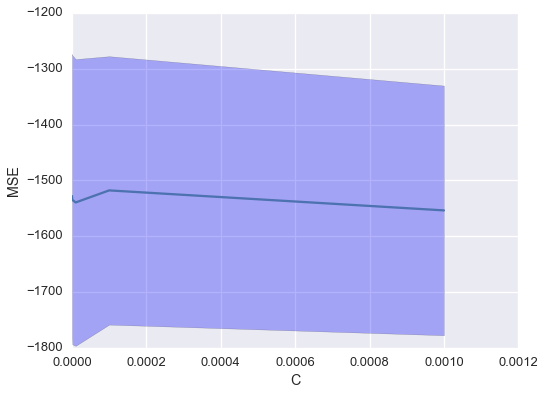

In [425]:
plot_quality(searcher, 'C')

In [426]:
est = LinearSVR(random_state=42, epsilon=1,\
                loss="squared_epsilon_insensitive", C=0.0001, fit_intercept=False).fit(three_week_X, three_week_y)

In [427]:
coefs = est.coef_

In [428]:
coefs.reshape((2, -1))

array([[ 0.22233754,  0.32631208,  0.41333824,  0.45157223,  0.42670871,
         0.44175511,  0.47864182],
       [ 0.58897353,  0.61633489,  0.56245246,  0.6197234 ,  0.64486292,
         0.68761943,  0.82046859]])

In [444]:
np.median((three_week_y - est.predict(three_week_X))**2)**0.5

15.103092348556959

In [429]:
1520 ** 0.5

38.98717737923585